In [ ]:
# List contents of the HAM10000 folder
!ls /content/drive/My\ Drive/HAM10000/



ls: cannot access '/content/drive/My Drive/HAM10000/': No such file or directory


In [ ]:
# Check GPU availability
!nvidia-smi

# Install required libraries
!pip install tensorflow matplotlib scikit-learn pandas opencv-python

# Mount Google Drive (to save your dataset and model)
from google.colab import drive
drive.mount('/content/drive')


/bin/bash: line 1: nvidia-smi: command not found
Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/HAM10000/'
!ls /content/drive/My\ Drive/HAM10000/
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/
!ls /content/drive/My\ Drive/HAM10000/

import pandas as pd

# Path to the metadata file
metadata_path = '/content/drive/My Drive/HAM10000/HAM10000_metadata.csv'

# Load metadata
metadata = pd.read_csv(metadata_path)

# Display metadata info
print(metadata.head())
print(metadata.info())


HAM10000_images_part_1	HAM10000_metadata.csv  hmnist_28_28_RGB.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_2	hmnist_28_28_L.csv     hmnist_8_8_L.csv
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 asp-final-ass.gdoc   dsp-planning.gdoc		'New Tenant Details.docx'
 CC-blog.gdoc	      dsp-t1.gdoc		"New Tenant - Shurida's Details.docx"
'Colab Notebooks'     HAM10000			 PeersinCareers-Shurida.gdoc
 DESD-draft.gdoc     'Inventory SBR 2024.gdoc'	 Shurida-Binte-Rahsed.pdf
 desd.gdoc	     'Inventory SBR 2024.pdf'
HAM10000_images_part_1	HAM10000_metadata.csv  hmnist_28_28_RGB.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_2	hmnist_28_28_L.csv     hmnist_8_8_L.csv
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male   

In [ ]:
import os
import cv2
import numpy as np

# Paths to image folders
image_dir_part1 = '/content/drive/My Drive/HAM10000/HAM10000_images_part_1/'
image_dir_part2 = '/content/drive/My Drive/HAM10000/HAM10000_images_part_2/'

# Function to load and preprocess images
def load_images(metadata, image_dir1, image_dir2):
    images, labels = [], []
    for index, row in metadata.iterrows():
        image_id = row['image_id']
        label = row['dx']  # Diagnosis column

        # Check if image is in part 1 or part 2
        if os.path.exists(image_dir1 + image_id + '.jpg'):
            image_path = image_dir1 + image_id + '.jpg'
        elif os.path.exists(image_dir2 + image_id + '.jpg'):
            image_path = image_dir2 + image_id + '.jpg'
        else:
            print(f"Image {image_id} not found!")
            continue

        # Load and preprocess image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(metadata, image_dir_part1, image_dir_part2)

print(f"Loaded {len(images)} images with shape {images[0].shape}")
print(f"Loaded {len(labels)} labels.")


Loaded 10015 images with shape (128, 128, 3)
Loaded 10015 labels.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Horizontal shift up to 20%
    height_shift_range=0.2,   # Vertical shift up to 20%
    shear_range=0.2,          # Shearing transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    validation_split=0.2      # Split into training (80%) and validation (20%)
)



In [ ]:
# Split images and labels into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


Training set: 8012 images
Validation set: 2003 images


In [ ]:
# Flow training images through the data generator
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,      # Number of images per batch
    subset='training'   # Training subset
)

# Flow validation images through the data generator
val_generator = datagen.flow(
    X_val, y_val,
    batch_size=32,      # Number of images per batch
    subset='validation' # Validation subset
)


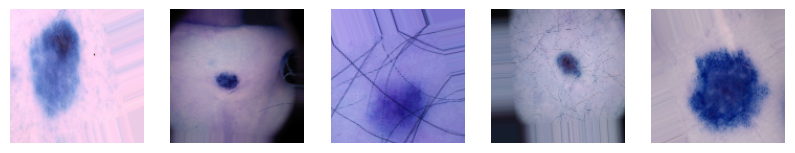

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularisation
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,       # You can adjust this
    steps_per_epoch=len(X_train) // 32,  # Number of steps per epoch
    validation_steps=len(X_val) // 32    # Validation steps
)


ValueError: Invalid dtype: str160

In [ ]:
print(labels[:10])  # Print the first 10 labels
print(type(labels[0]))  # Check the type of an individual label


['bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl']
<class 'numpy.str_'>


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Verify the encoded labels
print(f"Unique classes: {label_encoder.classes_}")
print(f"Encoded labels: {labels[:10]}")


Unique classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Encoded labels: [2 2 2 2 2 2 2 2 2 2]


In [ ]:
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,       # Adjust epochs as needed
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)


ValueError: Invalid dtype: str160

In [ ]:
# Use the encoded labels for training and validation datasets
train_generator = datagen.flow(
    X_train, y_train,  # Pass encoded labels here
    batch_size=32
)

val_generator = datagen.flow(
    X_val, y_val,  # Pass encoded labels here
    batch_size=32
)


In [ ]:
print(y_train[:10])  # Should show integers like [2, 2, 2, 2, ...]
print(y_val[:10])    # Should also show integers


[5 5 5 2 2 5 5 2 0 5]
[4 5 4 2 5 5 5 5 4 5]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,       # Adjust this as needed
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.6558 - loss: 1.1760 - val_accuracy: 0.6683 - val_loss: 0.9667
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 4:27 1s/step - accuracy: 0.7500 - loss: 0.9377

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7500 - loss: 0.9377 - val_accuracy: 0.6316 - val_loss: 0.9000
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.6639 - loss: 1.0174 - val_accuracy: 0.6704 - val_loss: 0.9681
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6875 - loss: 1.0800 - val_accuracy: 0.4211 - val_loss: 1.3492
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.6671 - loss: 0.9854 - val_accuracy: 0.6668 - val_loss: 0.9525
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.7188 - loss: 0.8813 - val_accuracy: 0.7368 - val_loss: 0.8161
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6763 - loss: 0.9049 - val_accuracy: 0.6699 - val_loss: 0.9119
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.5312 - loss: 1.0627 - val_accuracy: 0.4211 - val_loss: 1.2264
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.6633 - loss: 0.9320 - val_accuracy: 0.6

In [ ]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size



NameError: name 'batch_size' is not defined

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),  # Use the number of batches in the generator
    validation_steps=len(val_generator)   # Same for validation generator
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6653 - loss: 0.9340 - val_accuracy: 0.6740 - val_loss: 0.8475
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
 24/251 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.6679 - loss: 0.8889

KeyboardInterrupt: 

In [ ]:
# Use the number of batches available in the generators
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 251
Validation steps: 63


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,                # Adjust the number of epochs as needed
    steps_per_epoch=251,      # Correct number of steps for the training generator
    validation_steps=63       # Correct number of steps for the validation generator
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.6818 - loss: 0.8756 - val_accuracy: 0.6725 - val_loss: 0.8303
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.6725 - loss: 0.8613 - val_accuracy: 0.6815 - val_loss: 0.8277
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.6938 - loss: 0.8360 - val_accuracy: 0.7084 - val_loss: 0.7938
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.6962 - loss: 0.8008 - val_accuracy: 0.7094 - val_loss: 0.8674
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.7004 - loss: 0.7966 - val_accuracy: 

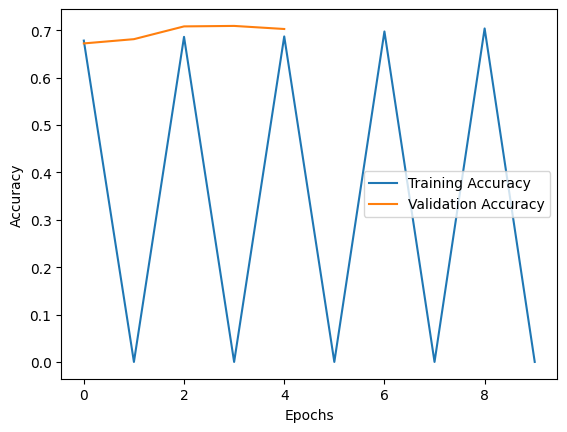

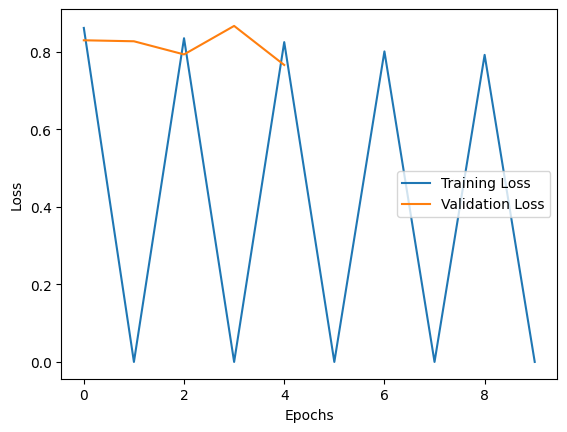

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


NameError: name 'model' is not defined

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


NameError: name 'model' is not defined

In [ ]:
# Save the trained model to Google Drive
model.save('/content/drive/My Drive/skin_disease_model.h5')

print("Model saved successfully!")


NameError: name 'model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/skin_disease_model.h5')
print("Model reloaded successfully!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/My Drive/skin_disease_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
!ls /content/drive/My\ Drive/


 asp-final-ass.gdoc   dsp-demo.gdoc		'Inventory SBR 2024.pdf'
 CC-blog.gdoc	      dsp-planning.gdoc		'New Tenant Details.docx'
'Colab Notebooks'     dsp-t1.gdoc		"New Tenant - Shurida's Details.docx"
 DESD-draft.gdoc      HAM10000			 PeersinCareers-Shurida.gdoc
 desd.gdoc	     'Inventory SBR 2024.gdoc'	 Shurida-Binte-Rahsed.pdf


In [ ]:
model.save('/content/drive/My Drive/skin_disease_model.h5')
print("Model saved successfully!")


NameError: name 'model' is not defined

In [ ]:
!ls /content/drive/My\ Drive/HAM10000/


HAM10000_images_part_1	HAM10000_metadata.csv  hmnist_28_28_RGB.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_2	hmnist_28_28_L.csv     hmnist_8_8_L.csv


In [ ]:
model.save('/content/drive/My Drive/skin_disease_model.h5')
print("Model saved successfully!")


NameError: name 'model' is not defined

In [ ]:
!ls /content/drive/My\ Drive/


 asp-final-ass.gdoc   dsp-demo.gdoc		'Inventory SBR 2024.pdf'
 CC-blog.gdoc	      dsp-planning.gdoc		'New Tenant Details.docx'
'Colab Notebooks'     dsp-t1.gdoc		"New Tenant - Shurida's Details.docx"
 DESD-draft.gdoc      HAM10000			 PeersinCareers-Shurida.gdoc
 desd.gdoc	     'Inventory SBR 2024.gdoc'	 Shurida-Binte-Rahsed.pdf


In [ ]:
!ls /content/drive/My\ Drive/HAM10000/Colab Notebooks

ls: cannot access '/content/drive/My Drive/HAM10000/Colab': No such file or directory
ls: cannot access 'Notebooks': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



MessageError: Error: credential propagation was unsuccessful

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(7, activation='softmax')  # 7 output classes (skin disease categories)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Model architecture defined successfully!")


Model architecture defined successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # You can increase this if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


NameError: name 'train_generator' is not defined

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Reload dataset (if necessary)
data_dir = "/content/drive/My Drive/HAM10000/"  # Adjust if needed

# Load preprocessed images and labels (assuming they were processed before)
# If you lost them, you'll need to reload them from metadata
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flipping
    brightness_range=[0.8, 1.2]  # Brightness adjustment
)

# Recreate the train and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("Data generators recreated successfully!")


NameError: name 'images' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Reload dataset (if necessary)
data_dir = "/content/drive/My Drive/HAM10000/"  # Adjust if needed

# Load preprocessed images and labels (assuming they were processed before)
# If you lost them, you'll need to reload them from metadata
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flipping
    brightness_range=[0.8, 1.2]  # Brightness adjustment
)

# Recreate the train and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("Data generators recreated successfully!")


NameError: name 'images' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the data directory
data_dir = '/content/drive/My Drive/HAM10000/'

# Load metadata
metadata = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

# Encode labels
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])

# Define image directories
image_dir1 = data_dir + 'HAM10000_images_part_1/'
image_dir2 = data_dir + 'HAM10000_images_part_2/'

# Initialize empty lists for images and labels
images, labels = [], []

# Load images and preprocess them
for index, row in metadata.iterrows():
    img_path = image_dir1 + row['image_id'] + '.jpg' if os.path.exists(image_dir1 + row['image_id'] + '.jpg') else image_dir2 + row['image_id'] + '.jpg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize images to 128x128
    images.append(img)
    labels.append(row['label'])

# Convert lists to NumPy arrays
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"Loaded {len(images)} images and {len(labels)} labels successfully!")


Loaded 10015 images and 10015 labels successfully!


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Create generators for training and validation data
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("Data generators recreated successfully!")


Data generators recreated successfully!


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.6536 - loss: 1.3036 - val_accuracy: 0.6680 - val_loss: 1.1738
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.6644 - loss: 1.1881 - val_accuracy: 0.6680 - val_loss: 1.2648
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.6648 - loss: 1.1713 - val_accuracy: 0.6680 - val_loss: 5.4954
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.6693 - loss: 1.1565 - val_accuracy: 0.6680 - val_loss: 32.0480
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.6649 - loss: 1.1674 - val_accuracy: 0.6680 - val_loss: 83.7744
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.6777 - loss: 1.1351 - val_accuracy: 0.6680 - val_loss: 110.4000
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6672 - loss: 1.1532 - val_accuracy: 0.6680 - val_loss: 6.1286
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.6729 - loss: 1.1491 - val_

In [ ]:
model.save('/content/drive/My Drive/skin_disease_model.h5')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
!ls /content/drive/My\ Drive/


 asp-final-ass.gdoc   dsp-planning.gdoc		"New Tenant - Shurida's Details.docx"
 CC-blog.gdoc	      dsp-t1.gdoc		 PeersinCareers-Shurida.gdoc
'Colab Notebooks'     HAM10000			 Shurida-Binte-Rahsed.pdf
 DESD-draft.gdoc     'Inventory SBR 2024.gdoc'	 skin_disease_model.h5
 desd.gdoc	     'Inventory SBR 2024.pdf'
 dsp-demo.gdoc	     'New Tenant Details.docx'


In [ ]:
model.save('/content/drive/My Drive/skin_disease_model.keras')
print("Model saved in the new Keras format!")


Model saved in the new Keras format!


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/skin_disease_model.keras')
print("Model reloaded successfully!")


Model reloaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


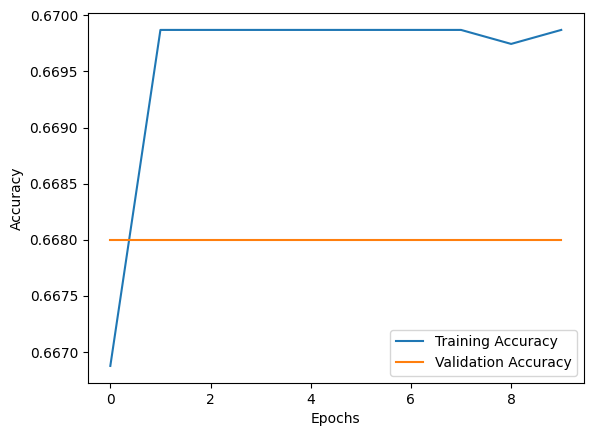

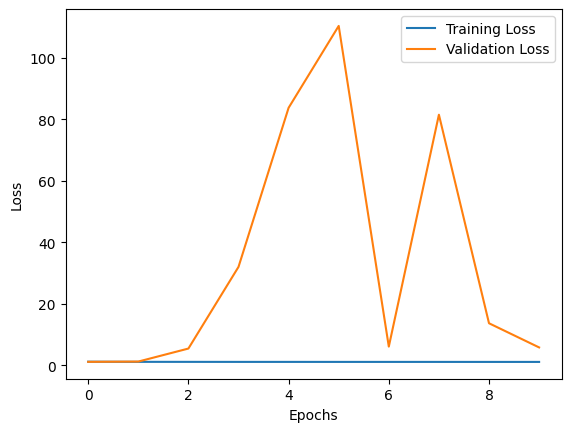

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - accuracy: 0.6724 - loss: 5.7247
Validation Accuracy: 66.80%


In [ ]:
# Split images and labels into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


NameError: name 'images' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"✅ Training set: {len(X_train)} images")
print(f"✅ Validation set: {len(X_val)} images")


NameError: name 'images' is not defined

In [ ]:
# Flow training images through the data generator
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,      # Number of images per batch
    subset='training'   # Training subset


SyntaxError: incomplete input (<ipython-input-3-f8367bcfd511>, line 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model

# Remount Google Drive first
drive.mount('/content/drive')

# Load the saved model
model = load_model('/content/drive/My Drive/skin_disease_model.h5')
print("Model reloaded successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model reloaded successfully!


In [ ]:
# Split images and labels into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


NameError: name 'images' is not defined

In [ ]:
try:
    print(f"Model exists: {model}")
    print(f"Training data: {len(X_train)} images")
except NameError:
    print("Some variables are missing. Re-run necessary parts!")


Model exists: <Sequential name=sequential, built=True>
Some variables are missing. Re-run necessary parts!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the data directory
data_dir = '/content/drive/My Drive/HAM10000/'  # Update path if needed

# Load metadata
metadata = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

# Encode labels
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])  # Convert disease labels into numbers

# Define image directories
image_dir1 = data_dir + 'HAM10000_images_part_1/'
image_dir2 = data_dir + 'HAM10000_images_part_2/'

# Initialize empty lists for images and labels
images, labels = [], []

# Load and preprocess images
for index, row in metadata.iterrows():
    img_path = image_dir1 + row['image_id'] + '.jpg' if os.path.exists(image_dir1 + row['image_id'] + '.jpg') else image_dir2 + row['image_id'] + '.jpg'

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  # Resize images to 128x128
        images.append(img)
        labels.append(row['label'])
    else:
        print(f"Warning: Image {row['image_id']} not found!")

# Convert lists to NumPy arrays
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"✅ Loaded {len(images)} images and {len(labels)} labels successfully!")


✅ Loaded 10015 images and 10015 labels successfully!


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"✅ Training set: {len(X_train)} images")
print(f"✅ Validation set: {len(X_val)} images")


✅ Training set: 8012 images
✅ Validation set: 2003 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Create training and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("✅ Data generators recreated successfully!")


✅ Data generators recreated successfully!


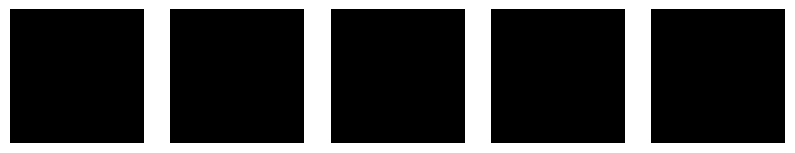

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


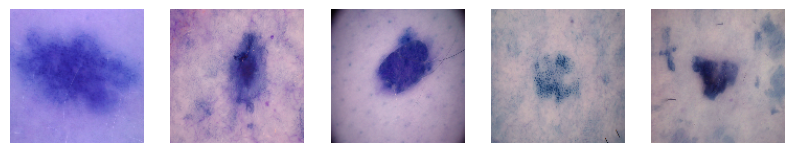

In [ ]:
import matplotlib.pyplot as plt

# Plot first 5 raw images before augmentation
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])  # Displaying original unaugmented images
    plt.axis('off')
plt.show()


In [ ]:
augmented_images, augmented_labels = next(train_generator)

# Print min and max pixel values
print(f"Min Pixel Value: {augmented_images.min()}")
print(f"Max Pixel Value: {augmented_images.max()}")


Min Pixel Value: 0.0
Max Pixel Value: 0.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Correct data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,  # ✅ Ensure rescaling is applied to avoid black images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Recreate train and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("✅ Data generators recreated successfully!")


NameError: name 'X_train' is not defined

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the data directory
data_dir = '/content/drive/My Drive/HAM10000/'

# Load metadata
metadata = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

# Encode labels
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])  # Convert disease labels into numbers

# Define image directories
image_dir1 = data_dir + 'HAM10000_images_part_1/'
image_dir2 = data_dir + 'HAM10000_images_part_2/'

# Initialize empty lists for images and labels
images, labels = [], []

# Load and preprocess images
for index, row in metadata.iterrows():
    img_path = image_dir1 + row['image_id'] + '.jpg' if os.path.exists(image_dir1 + row['image_id'] + '.jpg') else image_dir2 + row['image_id'] + '.jpg'

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  # Resize images to 128x128
        images.append(img)
        labels.append(row['label'])
    else:
        print(f"Warning: Image {row['image_id']} not found!")

# Convert lists to NumPy arrays
images = np.array(images) / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"✅ Loaded {len(images)} images and {len(labels)} labels successfully!")


✅ Loaded 10015 images and 10015 labels successfully!


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"✅ Training set: {len(X_train)} images")
print(f"✅ Validation set: {len(X_val)} images")


✅ Training set: 8012 images
✅ Validation set: 2003 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Correct data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,  # ✅ Ensure rescaling is applied to avoid black images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Recreate train and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("✅ Data generators recreated successfully!")


✅ Data generators recreated successfully!


In [ ]:
try:
    print(f"Training data: {len(X_train)} images")
    print(f"Train Generator: {train_generator}")
except NameError:
    print("Some variables are still missing. Check dataset loading!")


Training data: 8012 images
Train Generator: <keras.src.legacy.preprocessing.image.NumpyArrayIterator object at 0x787d989c3bd0>


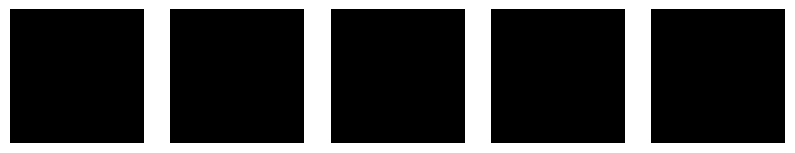

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])  # Should now display properly
    plt.axis('off')
plt.show()


In [ ]:
augmented_images, augmented_labels = next(train_generator)

# Print min and max pixel values
print(f"Min Pixel Value: {augmented_images.min()}")
print(f"Max Pixel Value: {augmented_images.max()}")


Min Pixel Value: 0.0
Max Pixel Value: 0.003921568859368563


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Correct data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,  # ✅ Ensure rescaling is applied to avoid black images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Recreate train and validation generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

print("✅ Data generators recreated successfully!")


NameError: name 'X_train' is not defined

In [ ]:
augmented_images, augmented_labels = next(train_generator)

# Print min and max pixel values
print(f"Min Pixel Value: {augmented_images.min()}")
print(f"Max Pixel Value: {augmented_images.max()}")


NameError: name 'train_generator' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 augmented images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])  # Should now display properly
    plt.axis('off')
plt.show()


NameError: name 'train_generator' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Path to the metadata file
metadata_path = '/content/drive/My Drive/HAM10000/HAM10000_metadata.csv'

# Load metadata
metadata = pd.read_csv(metadata_path)

# Display metadata info
print(metadata.head())
print(metadata.info())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [ ]:
import os
import cv2
import numpy as np

# Paths to image folders
image_dir_part1 = '/content/drive/My Drive/HAM10000/HAM10000_images_part_1/'
image_dir_part2 = '/content/drive/My Drive/HAM10000/HAM10000_images_part_2/'

# Function to load and preprocess images
def load_images(metadata, image_dir1, image_dir2):
    images, labels = [], []
    for index, row in metadata.iterrows():
        image_id = row['image_id']
        label = row['dx']  # Diagnosis column

        # Check if image is in part 1 or part 2
        if os.path.exists(image_dir1 + image_id + '.jpg'):
            image_path = image_dir1 + image_id + '.jpg'
        elif os.path.exists(image_dir2 + image_id + '.jpg'):
            image_path = image_dir2 + image_id + '.jpg'
        else:
            print(f"Image {image_id} not found!")
            continue

        # Load and preprocess image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(metadata, image_dir_part1, image_dir_part2)

print(f"Loaded {len(images)} images with shape {images[0].shape}")
print(f"Loaded {len(labels)} labels.")


Loaded 10015 images with shape (128, 128, 3)
Loaded 10015 labels.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Horizontal shift up to 20%
    height_shift_range=0.2,   # Vertical shift up to 20%
    shear_range=0.2,          # Shearing transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    validation_split=0.2      # Split into training (80%) and validation (20%)
)


In [ ]:
# Split images and labels into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


Training set: 8012 images
Validation set: 2003 images


In [ ]:
# Flow training images through the data generator
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,      # Number of images per batch
    subset='training'   # Training subset
)

# Flow validation images through the data generator
val_generator = datagen.flow(
    X_val, y_val,
    batch_size=32,      # Number of images per batch
    subset='validation' # Validation subset
)


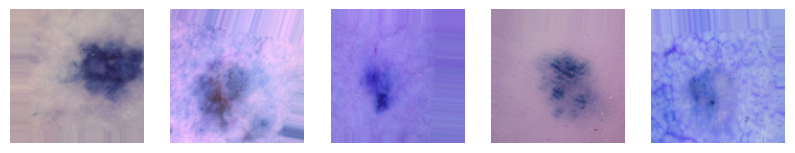

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularisation
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,       # You can adjust this
    steps_per_epoch=len(X_train) // 32,  # Number of steps per epoch
    validation_steps=len(X_val) // 32    # Validation steps
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Invalid dtype: str160

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


ValueError: Invalid dtype: str160

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


ValueError: Invalid dtype: str160

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()

# Convert string labels into numeric values
train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label'] = label_encoder.transform(val_df['label'])

# Check unique class values after encoding
print("Encoded Labels:", label_encoder.classes_)


NameError: name 'train_df' is not defined

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define data directory
data_dir = '/content/drive/My Drive/HAM10000/'

# Load metadata
metadata = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

# Encode labels
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])  # Convert disease labels into numbers

# Define image paths
metadata['image_path'] = metadata['image_id'].apply(lambda x: data_dir + 'HAM10000_images_part_1/' + x + '.jpg'
                                                    if os.path.exists(data_dir + 'HAM10000_images_part_1/' + x + '.jpg')
                                                    else data_dir + 'HAM10000_images_part_2/' + x + '.jpg')

print("✅ Metadata reloaded successfully!")


✅ Metadata reloaded successfully!


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42)

print(f"✅ Training set: {len(train_df)} samples")
print(f"✅ Validation set: {len(val_df)} samples")


✅ Training set: 8012 samples
✅ Validation set: 2003 samples


In [ ]:
# Convert string labels into numeric values
train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label'] = label_encoder.transform(val_df['label'])

# Check encoded labels
print("Encoded Labels:", label_encoder.classes_)


Encoded Labels: [0 1 2 3 4 5 6]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,  # ✅ Prevents black images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Create train and validation generators with corrected numeric labels
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'  # ✅ Ensures labels are integers
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'  # ✅ Ensures labels are integers
)

print("✅ Data generators recreated successfully!")


TypeError: If class_mode="sparse", y_col="label" column values must be strings.

In [ ]:
# Convert numerical labels back to string format
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Confirm conversion
print("Sample Training Labels (as strings):", train_df['label'].head())
print("Sample Validation Labels (as strings):", val_df['label'].head())


Sample Training Labels (as strings): 6582    5
7194    5
9446    5
533     2
132     2
Name: label, dtype: object
Sample Validation Labels (as strings): 1617    4
8128    5
2168    4
1090    2
7754    5
Name: label, dtype: object


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Horizontal shift up to 20%
    height_shift_range=0.2,   # Vertical shift up to 20%
    shear_range=0.2,          # Shearing transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    validation_split=0.2      # ✅ Split into training (80%) and validation (20%)
)

print("✅ Data augmentation settings updated!")


✅ Data augmentation settings updated!


In [ ]:
# Create train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',  # ✅ Sparse ensures integer labels
    subset='training'  # ✅ Use 80% for training
)

# Create validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation'  # ✅ Use 20% for validation
)

print("✅ Train and validation generators created successfully!")


Found 6410 validated image filenames belonging to 7 classes.
Found 400 validated image filenames belonging to 7 classes.
✅ Train and validation generators created successfully!


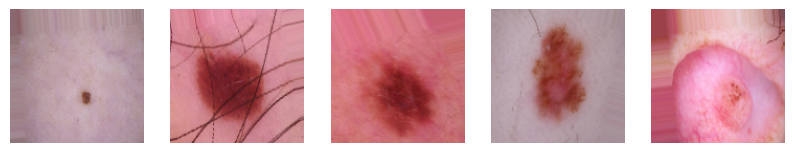

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot the first 5 images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])  # ✅ Should now show correctly
    plt.axis('off')
plt.show()


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.6584 - loss: 1.1472 - val_accuracy: 0.6375 - val_loss: 1.0511
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6668 - loss: 1.0285 - val_accuracy: 0.6375 - val_loss: 0.9887
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6789 - loss: 0.9156 - val_accuracy: 0.6375 - val_loss: 1.0028
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.6789 - loss: 0.9142 - val_accuracy: 0.6425 - val_loss: 0.9302
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.6730 - loss: 0.9132 - val_accuracy: 0.6450 - val_loss: 0.8784
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.6757 - loss: 0.8816 - val_accuracy: 0.6350 - val_loss: 0.9804
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.6762 - loss: 0.8939 - val_accuracy: 0.6400 - val_loss: 0.8842
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.6657 - loss: 0.8884 - val_accu

In [ ]:
# Define save path
model_path = "/content/drive/My Drive/skin_disease_model.keras"

# Save model
model.save(model_path)

print(f"✅ Model saved at: {model_path}")


✅ Model saved at: /content/drive/My Drive/skin_disease_model.keras


In [ ]:
import os

if os.path.exists(model_path):
    print("✅ Model successfully saved in Google Drive!")
else:
    print("❌ Model saving failed!")


✅ Model successfully saved in Google Drive!


In [ ]:
import numpy as np

# Get a batch of validation images
sample_images, sample_labels = next(val_generator)

# Make predictions
predictions = model.predict(sample_images)

# Get the predicted class
predicted_classes = np.argmax(predictions, axis=1)

print(f"Predicted Classes: {predicted_classes}")
print(f"Actual Classes: {sample_labels}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Predicted Classes: [5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Actual Classes: [5. 5. 5. 5. 5. 5. 0. 5. 5. 5. 5. 5. 5. 5. 4. 2. 5. 5. 5. 5. 5. 5. 4. 5.
 5. 5. 4. 5. 5. 5. 5. 5.]


In [ ]:
try:
    print(f"Model Exists: {model}")
except NameError:
    print("❌ Model is not defined! You need to run the CNN architecture setup.")


Model Exists: <Sequential name=sequential, built=True>


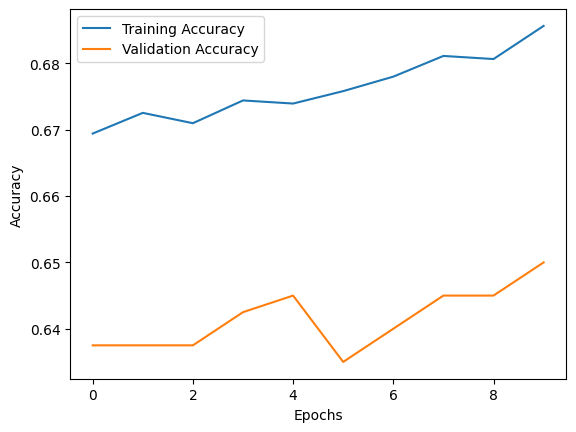

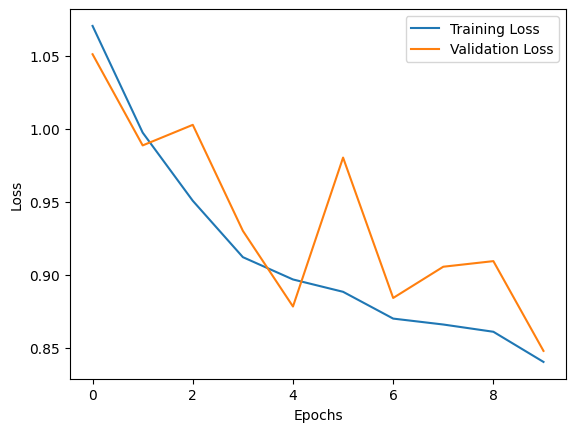

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step - accuracy: 0.6268 - loss: 0.9191
Validation Accuracy: 65.25%


In [ ]:
import numpy as np

# Get a batch of validation images
sample_images, sample_labels = next(val_generator)

# Make predictions
predictions = model.predict(sample_images)

# Get predicted class
predicted_classes = np.argmax(predictions, axis=1)

print(f"Predicted Classes: {predicted_classes}")
print(f"Actual Classes: {sample_labels}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Predicted Classes: [5 5 5 5 5 5 5 5 6 5 6 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Actual Classes: [1. 0. 5. 2. 5. 5. 5. 5. 6. 2. 6. 5. 5. 5. 5. 5. 4. 4. 5. 5. 5. 5. 5. 4.
 5. 5. 5. 3. 5. 2. 5. 5.]


In [ ]:
print(f"Total validation samples: {len(val_generator.filenames)}")
print(f"Batch size: {val_generator.batch_size}")
print(f"Expected validation steps: {len(val_generator.filenames) // val_generator.batch_size}")


Total validation samples: 400
Batch size: 32
Expected validation steps: 12


In [ ]:
print(f"Training Samples: {len(train_generator.filenames)}")
print(f"Validation Samples: {len(val_generator.filenames)}")


Training Samples: 6410
Validation Samples: 400


In [ ]:
# Define model save path
model_path = "/content/drive/My Drive/skin_disease_model.keras"

# Save the model
model.save(model_path)

print(f"✅ Model saved at: {model_path}")


✅ Model saved at: /content/drive/My Drive/skin_disease_model.keras


In [ ]:
import pickle

# Save training history
history_path = "/content/drive/My Drive/skin_disease_training_history.pkl"

with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print(f"✅ Training history saved at: {history_path}")


✅ Training history saved at: /content/drive/My Drive/skin_disease_training_history.pkl


In [ ]:
!cp /content/SkinAid.ipynb "/content/drive/My Drive/SkinAid_backup.ipynb"
print("✅ Notebook saved to Google Drive!")


cp: cannot stat '/content/SkinAid.ipynb': No such file or directory
✅ Notebook saved to Google Drive!


In [ ]:
import pandas as pd

# Save training and validation data
train_df.to_csv("/content/drive/My Drive/skin_disease_train_data.csv", index=False)
val_df.to_csv("/content/drive/My Drive/skin_disease_val_data.csv", index=False)

print("✅ Data saved successfully!")


✅ Data saved successfully!


In [ ]:
import os

paths = [
    "/content/drive/My Drive/skin_disease_model.keras",
    "/content/drive/My Drive/skin_disease_training_history.pkl",
    "/content/drive/My Drive/skin_disease_train_data.csv",
    "/content/drive/My Drive/skin_disease_val_data.csv"
]

for path in paths:
    if os.path.exists(path):
        print(f"✅ File found: {path}")
    else:
        print(f"❌ Missing file: {path}")


✅ File found: /content/drive/My Drive/skin_disease_model.keras
✅ File found: /content/drive/My Drive/skin_disease_training_history.pkl
✅ File found: /content/drive/My Drive/skin_disease_train_data.csv
✅ File found: /content/drive/My Drive/skin_disease_val_data.csv


In [1]:
from tensorflow.keras.models import load_model
import pickle
import pandas as pd

# Load model
model = load_model("/content/drive/My Drive/skin_disease_model.keras")
print("✅ Model reloaded!")

# Load training history
with open("/content/drive/My Drive/skin_disease_training_history.pkl", 'rb') as f:
    history = pickle.load(f)

print("✅ Training history reloaded!")

# Load preprocessed data
train_df = pd.read_csv("/content/drive/My Drive/skin_disease_train_data.csv")
val_df = pd.read_csv("/content/drive/My Drive/skin_disease_val_data.csv")

print("✅ Preprocessed data reloaded!")


ValueError: File not found: filepath=/content/drive/My Drive/skin_disease_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/skin_disease_model.keras')
print("✅ Model reloaded successfully!")


✅ Model reloaded successfully!


In [4]:
import pandas as pd

train_df = pd.read_csv('/content/drive/My Drive/skin_disease_train_data.csv')
val_df = pd.read_csv('/content/drive/My Drive/skin_disease_val_data.csv')

print("✅ Preprocessed data reloaded!")


✅ Preprocessed data reloaded!


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False  # ⚠️ Important for correct label ordering during evaluation
)


TypeError: If class_mode="sparse", y_col="label" column values must be strings.

In [6]:
# Convert labels to string format
val_df['label'] = val_df['label'].astype(str)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator again (if needed)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False  # Don't shuffle for evaluation consistency
)


Found 400 validated image filenames belonging to 7 classes.


In [8]:
import numpy as np

# Predict probabilities
pred_probs = model.predict(val_generator, verbose=1)

# Get predicted class labels
y_pred = np.argmax(pred_probs, axis=1)

# Get true labels from generator
y_true = val_generator.classes


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step


In [9]:
from sklearn.metrics import classification_report

# Get label names (class indices are sorted)
labels = list(val_generator.class_indices.keys())

# Print report
report = classification_report(y_true, y_pred, target_names=labels)
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.38      0.29      0.32        21
           2       0.20      0.02      0.04        44
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        52
           5       0.68      0.98      0.80       255
           6       0.50      0.75      0.60         8

    accuracy                           0.66       400
   macro avg       0.25      0.29      0.25       400
weighted avg       0.48      0.66      0.54       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


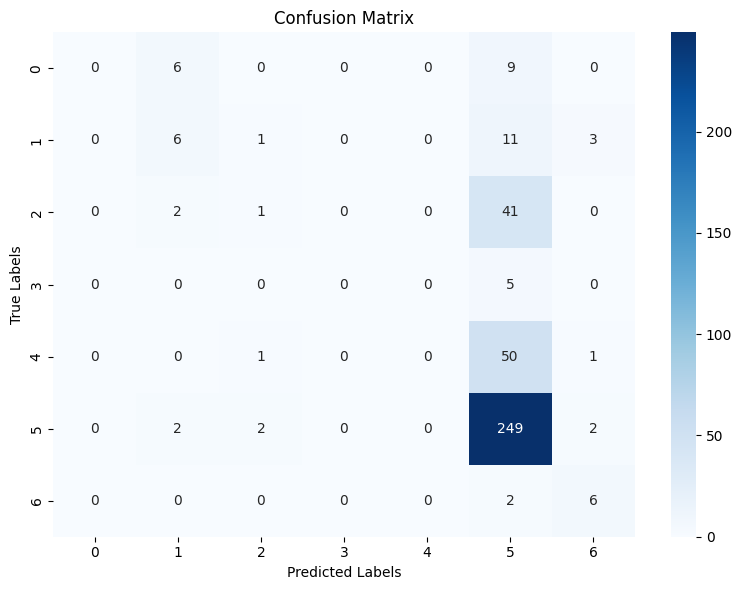

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



In [11]:
import os

# Check if files exist in /content
test_images = [
    "ISIC_0024406.jpg", "ISIC_0024410.jpg", "ISIC_0024411.jpg",
    "ISIC_0024417.jpg", "ISIC_0024419.jpg", "ISIC_0024420.jpg",
    "ISIC_0024426.jpg", "ISIC_0024427.jpg", "ISIC_0024429.jpg",
    "ISIC_0024431.jpg"
]

for img in test_images:
    print(f"{img}: {'✅ Found' if os.path.exists('/content/' + img) else '❌ Missing'}")


ISIC_0024406.jpg: ✅ Found
ISIC_0024410.jpg: ✅ Found
ISIC_0024411.jpg: ✅ Found
ISIC_0024417.jpg: ✅ Found
ISIC_0024419.jpg: ✅ Found
ISIC_0024420.jpg: ✅ Found
ISIC_0024426.jpg: ✅ Found
ISIC_0024427.jpg: ✅ Found
ISIC_0024429.jpg: ✅ Found
ISIC_0024431.jpg: ✅ Found


In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get label mapping from val_generator
class_names = list(val_generator.class_indices.keys())

# Function to load and predict a single image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return predicted_class, confidence


In [13]:
# List of test image filenames (already confirmed they exist)
test_images = [
    "ISIC_0024406.jpg", "ISIC_0024410.jpg", "ISIC_0024411.jpg",
    "ISIC_0024417.jpg", "ISIC_0024419.jpg", "ISIC_0024420.jpg",
    "ISIC_0024426.jpg", "ISIC_0024427.jpg", "ISIC_0024429.jpg",
    "ISIC_0024431.jpg"
]

plt.figure(figsize=(20, 8))

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)

    # Show prediction
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_names[pred_class]}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [14]:
plt.figure(figsize=(20, 8))

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]  # Convert class index to name

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [15]:
# Define class names manually (ensure order matches your model's class indices)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [16]:
plt.figure(figsize=(20, 8))

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]  # Convert class index to name

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [17]:
import os

# Check if files exist in /content
test_images = [
    "t1.jpg", "t2.jpg", "t3.jpg",
]

for img in test_images:
    print(f"{img}: {'✅ Found' if os.path.exists('/content/' + img) else '❌ Missing'}")

t1.jpg: ✅ Found
t2.jpg: ✅ Found
t3.jpg: ✅ Found


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


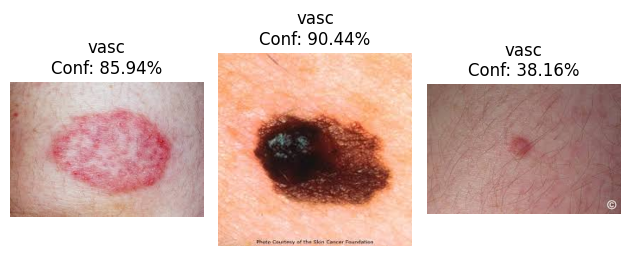

In [18]:
# Replace with your new test image names
test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get label mapping from val_generator
class_names = list(val_generator.class_indices.keys())

# Function to load and predict a single image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


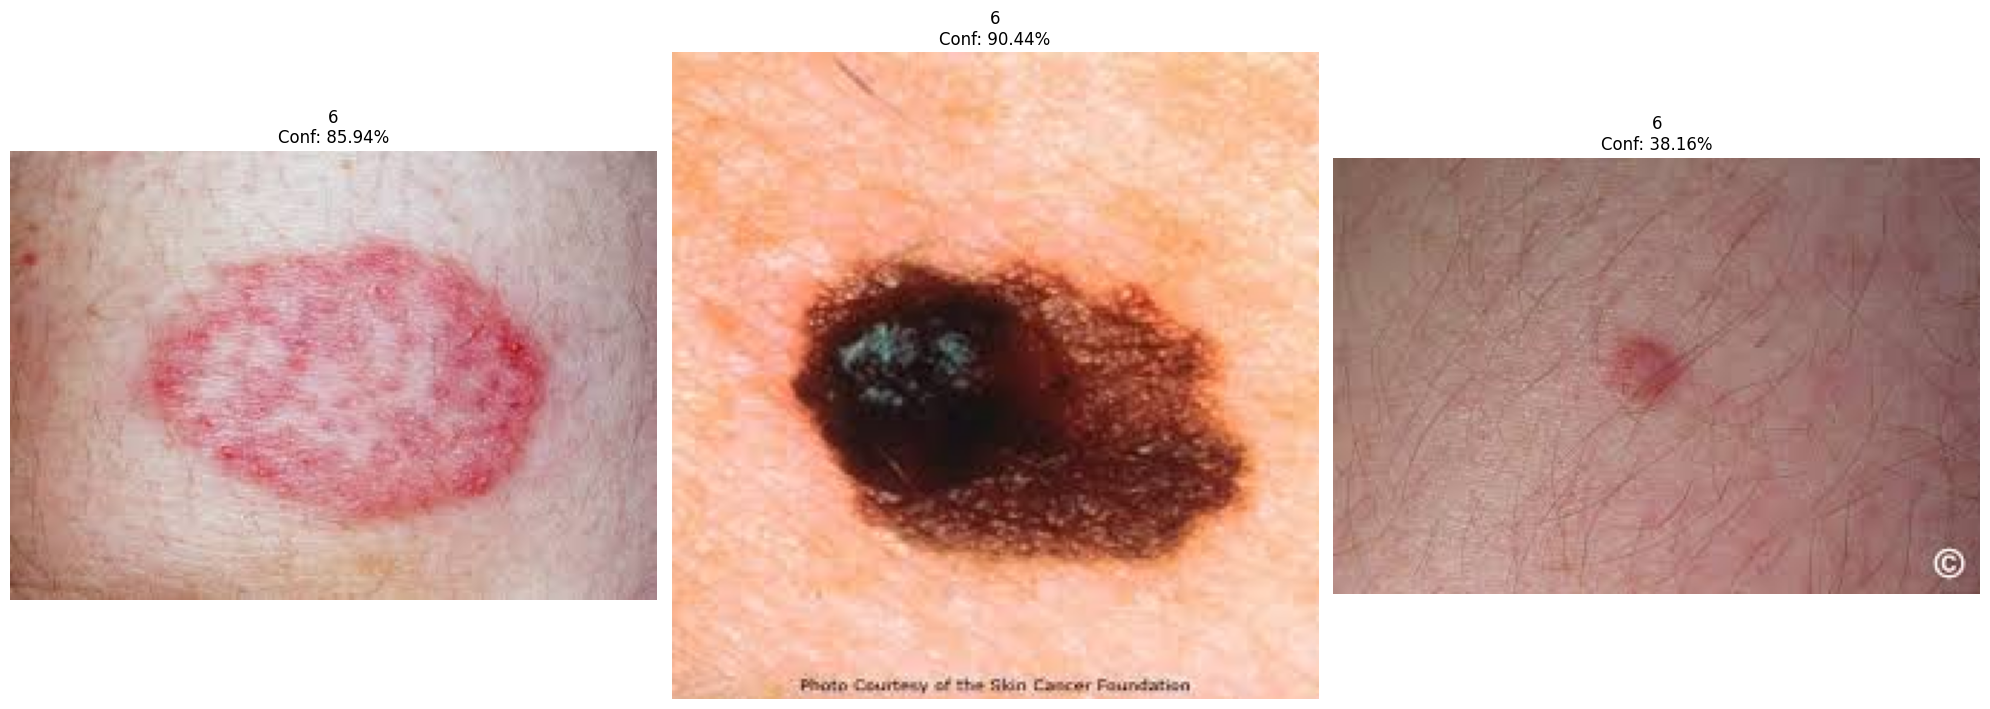

In [20]:
plt.figure(figsize=(20, 8))

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]  # Convert class index to name

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


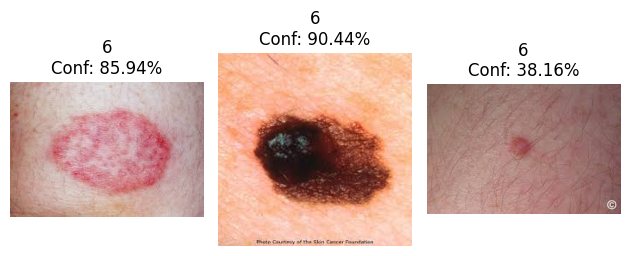

In [21]:
# Replace with your new test image names
test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


In [22]:
# Define class names manually (ensure order matches your model's class indices)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


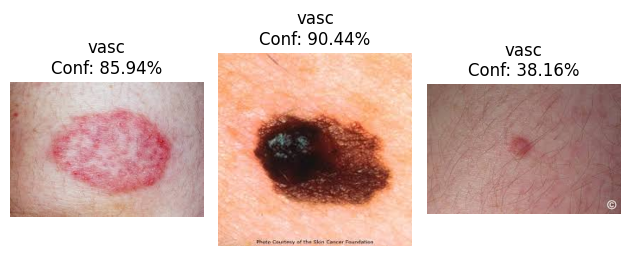

In [23]:
# Replace with your new test image names
test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]

for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    predicted_label = class_names[pred_class]

    # Load and show image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


In [24]:
from tensorflow.keras.optimizers import Adam

# Compile again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning: small LR
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [25]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # You can increase to 10 if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


NameError: name 'train_generator' is not defined

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


Found 1603 validated image filenames belonging to 7 classes.
Found 400 validated image filenames belonging to 7 classes.


In [27]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # You can increase to 10 if needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 428s 8s/step - accuracy: 0.6811 - loss: 0.8347 - val_accuracy: 0.6525 - val_loss: 0.8273
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6978 - loss: 0.8479 - val_accuracy: 0.6550 - val_loss: 0.8232
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6986 - loss: 0.8198 - val_accuracy: 0.6650 - val_loss: 0.8189
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7015 - loss: 0.8128 - val_accuracy: 0.6675 - val_loss: 0.8177
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7067 - loss: 0.7719 - val_accuracy: 0.6625 - val_loss: 0.8166


In [28]:
model.save('/content/drive/My Drive/skin_disease_model_finetuned.h5')
print("✅ Fine-tuned model saved!")


✅ Fine-tuned model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


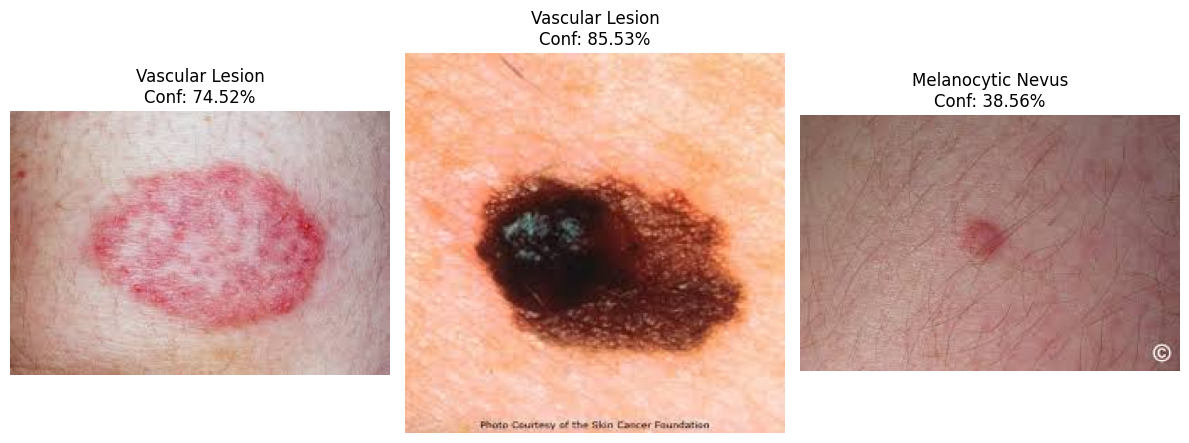

In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Class label mapping (full names)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_full_names = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevus',
    'vasc': 'Vascular Lesion'
}

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dim
    pred = model.predict(img)[0]
    class_index = np.argmax(pred)
    confidence = pred[class_index]
    return class_index, confidence

# List of test images
test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]

# Plot predictions
plt.figure(figsize=(12, 5))
for i, img_name in enumerate(test_images):
    img_path = f"/content/{img_name}"
    pred_class, confidence = predict_image(img_path)
    label = class_names[pred_class]
    full_label = class_full_names[label]

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{full_label}\nConf: {confidence*100:.2f}%")

plt.tight_layout()
plt.show()


In [30]:
model.save('/content/drive/My Drive/skin_disease_model_finetuned.h5')
print("✅ Fine-tuned model saved successfully!")


✅ Fine-tuned model saved successfully!


In [31]:
import pickle

with open('/content/drive/My Drive/skin_disease_finetune_history.pkl', 'wb') as f:
    pickle.dump(fine_tune_history.history, f)

print("✅ Fine-tuning history saved!")


✅ Fine-tuning history saved!


In [32]:
import os

paths = [
    '/content/drive/My Drive/skin_disease_model_finetuned.h5',
    '/content/drive/My Drive/skin_disease_finetune_history.pkl',
    '/content/drive/My Drive/skin_disease_train_data.csv',
    '/content/drive/My Drive/skin_disease_val_data.csv'
]

for path in paths:
    print(f"{'✅' if os.path.exists(path) else '❌'} {path}")


✅ /content/drive/My Drive/skin_disease_model_finetuned.h5
✅ /content/drive/My Drive/skin_disease_finetune_history.pkl
✅ /content/drive/My Drive/skin_disease_train_data.csv
✅ /content/drive/My Drive/skin_disease_val_data.csv


In [33]:
import pandas as pd
import cv2
import numpy as np

# Your unseen images
test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]

# Store predictions here
predictions_list = []

for img_name in test_images:
    img_path = f"/content/{img_name}"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    pred_class = np.argmax(pred)
    confidence = float(np.max(pred))

    predictions_list.append({
        "Image": img_name,
        "Predicted_Class": class_names[str(pred_class)],
        "Confidence (%)": round(confidence * 100, 2)
    })

# Create DataFrame
pred_df = pd.DataFrame(predictions_list)

# Save to CSV
csv_path = "/content/unseen_predictions.csv"
pred_df.to_csv(csv_path, index=False)

print(f"✅ Saved predictions to {csv_path}")
pred_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


TypeError: list indices must be integers or slices, not str

In [34]:
import pandas as pd
import cv2
import numpy as np

test_images = ["t1.jpg", "t2.jpg", "t3.jpg"]
predictions_list = []

for img_name in test_images:
    img_path = f"/content/{img_name}"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    pred_class = np.argmax(pred)
    confidence = float(np.max(pred))

    predictions_list.append({
        "Image": img_name,
        "Predicted_Class": class_names[pred_class],
        "Confidence (%)": round(confidence * 100, 2)
    })

pred_df = pd.DataFrame(predictions_list)

csv_path = "/content/unseen_predictions.csv"
pred_df.to_csv(csv_path, index=False)

print(f"✅ Saved predictions to {csv_path}")
pred_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
✅ Saved predictions to /content/unseen_predictions.csv


,Image,Predicted_Class,Confidence (%)
0,t1.jpg,vasc,74.52
1,t2.jpg,vasc,85.53
2,t3.jpg,nv,38.56


from matplotlib import pyplot as plt
pred_df['Confidence (%)'].plot(kind='hist', bins=20, title='Confidence (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
pred_df.groupby('Image').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
pred_df.groupby('Predicted_Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pred_df['Confidence (%)'].plot(kind='line', figsize=(8, 4), title='Confidence (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Predicted_Class'].value_counts()
    for x_label, grp in pred_df.groupby('Image')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Image')
_ = plt.ylabel('Predicted_Class')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(pred_df['Image'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(pred_df, x='Confidence (%)', y='Image', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(pred_df['Predicted_Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(pred_df, x='Confidence (%)', y='Predicted_Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [35]:
import pandas as pd
import cv2
import numpy as np

test_images = ["ISIC_0024406.jpg", "ISIC_0024410.jpg", "ISIC_0024411.jpg",
    "ISIC_0024417.jpg", "ISIC_0024419.jpg", "ISIC_0024420.jpg",
    "ISIC_0024426.jpg", "ISIC_0024427.jpg", "ISIC_0024429.jpg",
    "ISIC_0024431.jpg"]
predictions_list = []

for img_name in test_images:
    img_path = f"/content/{img_name}"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    pred_class = np.argmax(pred)
    confidence = float(np.max(pred))

    predictions_list.append({
        "Image": img_name,
        "Predicted_Class": class_names[pred_class],
        "Confidence (%)": round(confidence * 100, 2)
    })

pred_df = pd.DataFrame(predictions_list)

csv_path = "/content/unseen_predictions.csv"
pred_df.to_csv(csv_path, index=False)

print(f"✅ Saved predictions to {csv_path}")
pred_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
✅ Saved predictions to /content/unseen_predictions.csv


,Image,Predicted_Class,Confidence (%)
0,ISIC_0024406.jpg,vasc,36.83
1,ISIC_0024410.jpg,vasc,76.23
2,ISIC_0024411.jpg,nv,34.13
3,ISIC_0024417.jpg,mel,52.67
4,ISIC_0024419.jpg,mel,50.80
5,ISIC_0024420.jpg,vasc,53.60
6,ISIC_0024426.jpg,nv,30.23
7,ISIC_0024427.jpg,vasc,75.55
8,ISIC_0024429.jpg,vasc,95.69
9,ISIC_0024431.jpg,nv,25.04


from matplotlib import pyplot as plt
pred_df['Confidence (%)'].plot(kind='hist', bins=20, title='Confidence (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
pred_df.groupby('Predicted_Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pred_df['Confidence (%)'].plot(kind='line', figsize=(8, 4), title='Confidence (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(pred_df['Predicted_Class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(pred_df, x='Confidence (%)', y='Predicted_Class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [36]:
# Define model save path
model_path = "/content/drive/My Drive/skin_disease_model.keras"

# Save the model
model.save(model_path)

print(f"✅ Model saved at: {model_path}")

✅ Model saved at: /content/drive/My Drive/skin_disease_model.keras
